# Machine Learning avec PySpark et MLlib : résoudre un problème de classification binaire
Ici, J'ai esseye de créer une application d'une classification binaire à l'aide de l'API PySpark et MLlib Pipelines.

Nous avons essayé les algorithmes de régression logistique,Decision Tree, Random Forest et  Gradient-Boosted Tree.
le Gradient-Boosted Tree donne des meilleurs résultats sur l'ensemble de données.

## Exploring Dataset
L'ensemble de données qu'on va travailler avec est lié aux campagnes de marketing direct (appels téléphoniques) d'une institution bancaire portugaise. L'objectif de la classification est de prédire si le client souscrira (Oui/Non) à un dépôt à terme. L'ensemble de données peut être téléchargé à partir de Kaggle.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ml-bank').getOrCreate()
sdf = spark.read.csv('bank.csv', header = True, inferSchema = True)
sdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [2]:
sdf.count()

11162

**Input variables:** age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome

**Output variable:** deposit

Regardons les cinq premières observations. Le Pandas DataFrame est plus joli que la méthode Spark DataFrame show().

In [3]:
import pandas as pd

pd.DataFrame(sdf.take(5), columns=sdf.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


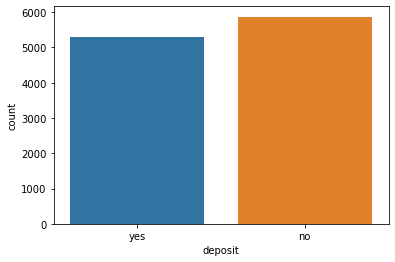

In [4]:
#Printing the classes of the Target Column
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sdf_pd=sdf.toPandas()
x = sdf_pd['deposit']
ax = sns.countplot(x=x, data=sdf_pd)

les classe du Dataset sont parfaitement equilibre.

In [5]:
sdf.toPandas().groupby(['deposit']).size()

deposit
no     5873
yes    5289
dtype: int64

In [7]:
sdf.toPandas().shape

(11162, 17)

### Statistiques Resumé des variables numérique

In [8]:
numeric_features = [t[0] for t in sdf.dtypes if t[1] == 'int']
sdf.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


### Etude de Correlations entre les variables

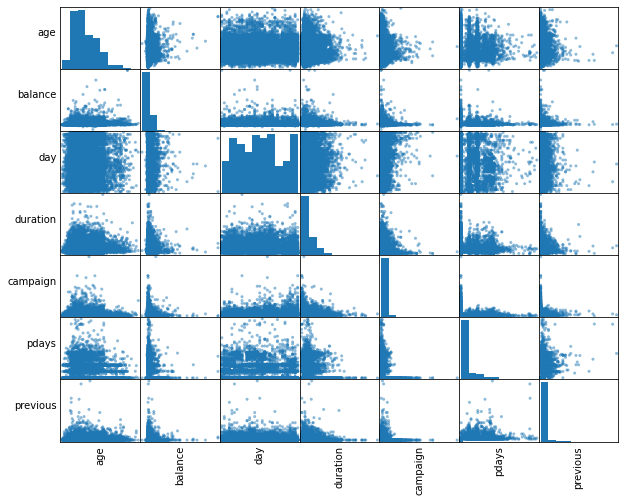

In [9]:

numeric_data = sdf.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(10, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

Il est évident qu'il n'y a pas de variables numériques fortement corrélées. Par conséquent, nous les conserverons tous pour le modèle.

Cependant, les colonnes day et month ne sont pas vraiment utiles, nous allons supprimer ces deux colonnes.

In [11]:
sdf = sdf.select(
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 
    'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit'
)
cols = sdf.columns
sdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



## Preparer le Dataset pour le Machine Learning

Le processus comprend **Category Indexing**, **One-Hot Encoding** et **VectorAssembler** (un transformateur de caractéristiques qui fusionne plusieurs colonnes en une colonne vectorielle).

Ce code indexe chaque colonne catégorielle à l'aide du <code>StringIndexer</code>, puis convertit les catégories indexées en variables *one-hot encoded*. La sortie résultante a des vecteurs binaires ajoutés à la fin de chaque ligne. Nous utilisons à nouveau <code>StringIndexer</code> pour encoder nos étiquettes en index d'étiquettes. Ensuite, nous utilisons le <code>VectorAssembler</code> pour combiner toutes les colonnes de caractéristiques en une seule colonne vectorielle.

In [12]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

stages = []
categoricalColumns = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'
]

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(
        inputCols=[stringIndexer.getOutputCol()], 
        outputCols=[categoricalCol + "classVec"]
    )
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

### Pipeline

Nous utilisons <code>Pipeline</code> pour enchaîner plusieurs transformateurs et estimateurs afin de spécifier le flux de travail du **Machine Learning**. 


In [13]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(sdf)
sdf = pipelineModel.transform(sdf)
selectedCols = ['label', 'features'] + cols
sdf = sdf.select(selectedCols)
sdf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



Nous avons maintenant la colonne <code>features</code> et la colonne <code>label</code>.

In [16]:
pdf = pd.DataFrame(sdf.take(5), columns=sdf.columns)
pdf.iloc[:,0:2] 


,label,features
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Diviser le dataset en train set et test set

Divisez les données de manière aléatoire en ensembles d'apprentissage et de test, et définissez des semences (seed) pour la reproductibilité.

In [17]:
train, test = sdf.randomSplit([0.7, 0.3], seed = 2022)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7796
Test Dataset Count: 3366


## Logistic Regression Model


In [18]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

Résumez le modèle sur l'ensemble d'apprentissage (train set), nous pouvons également obtenir la (**ROC Receiver-Operating Characteristic)** et la **Zone sous ROC** (<code>areaUnderROC</code>).

C:\ProgramData\Anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


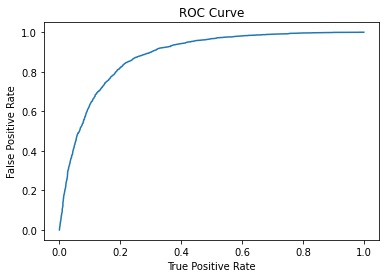

Training set areaUnderROC: 0.8827382468420814


In [19]:
trainingSummary = lrModel.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Precision and recall

C:\ProgramData\Anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


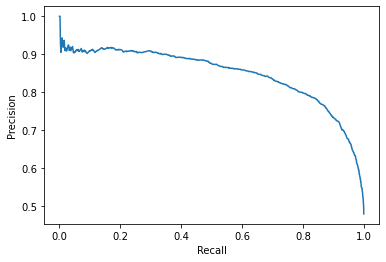

In [35]:
##Affichage du precision et le recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Predire les output du test set

In [21]:
lrPreds = lrModel.transform(test)
lrPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 34|management|  0.0|[0.24721777000263...|       0.0|[0.56149158121545...|
| 35|management|  0.0|[1.65482453099977...|       0.0|[0.83954203395211...|
| 42|management|  0.0|[0.16332571279442...|       0.0|[0.54074090382353...|
| 46|management|  0.0|[-0.8862355428576...|       1.0|[0.29188728968544...|
| 52|management|  0.0|[1.25002985148744...|       0.0|[0.77730502856729...|
| 52|management|  0.0|[-0.8117711955999...|       1.0|[0.30751319313314...|
| 53|management|  0.0|[0.82840698724868...|       0.0|[0.69601799033233...|
| 67|management|  0.0|[-0.9945130721175...|       1.0|[0.27002158359010...|
| 32|management|  0.0|[1.12143050611604...|       0.0|[0.75425396422657...|
| 46|management|  0.0|[1.94055976407808...|       0.0|[0.87441362654554...|
+---+-------

In [22]:
##Affichage des predictions avec pandas pour une bonne lecture
lrPreds.toPandas()

,label,features,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,deposit,rawPrediction,probability,prediction
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",34,management,married,secondary,no,355,no,no,cellular,314,3,-1,0,unknown,no,"[0.24721777000263145, -0.24721777000263145]","[0.5614915812154577, 0.4385084187845423]",0.0
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",35,management,married,secondary,no,533,no,no,cellular,221,12,-1,0,unknown,no,"[1.6548245309997789, -1.6548245309997789]","[0.8395420339521182, 0.16045796604788176]",0.0
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",42,management,married,secondary,no,1018,no,no,cellular,305,2,-1,0,unknown,no,"[0.16332571279442654, -0.16332571279442654]","[0.540740903823537, 0.459259096176463]",0.0
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",46,management,married,secondary,no,5127,no,no,cellular,472,1,-1,0,unknown,no,"[-0.8862355428576039, 0.8862355428576039]","[0.2918872896854479, 0.7081127103145521]",1.0
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",52,management,married,secondary,no,189,no,no,cellular,90,2,-1,0,unknown,no,"[1.2500298514874422, -1.2500298514874422]","[0.7773050285672911, 0.2226949714327089]",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3361,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",58,unknown,married,unknown,no,1547,no,no,telephone,1186,4,-1,0,unknown,yes,"[-4.104518081504418, 4.104518081504418]","[0.016230202247803114, 0.9837697977521969]",1.0
3362,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",78,unknown,married,unknown,no,2235,no,no,telephone,300,3,-1,0,unknown,yes,"[0.17522293890249863, -0.17522293890249863]","[0.54369399687402, 0.45630600312598]",0.0
3363,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",28,unknown,single,secondary,no,4465,no,no,cellular,769,1,-1,0,unknown,yes,"[-2.744411857154023, 2.744411857154023]","[0.060403024415561446, 0.9395969755844386]",1.0
3364,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",37,unknown,single,tertiary,no,0,no,no,cellular,257,2,97,1,success,yes,"[-2.789484703927722, 2.789484703927722]","[0.05789505477995425, 0.9421049452200457]",1.0


### Evaluer le Modele de la Regression Logistique

In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lrEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', lrEval.evaluate(lrPreds))

Test Area Under ROC 0.8960132937550602


## Decision Tree Classifier

**Les arbres de décision** sont largement utilisés car ils sont faciles à interpréter, gèrent les caractéristiques catégorielles, s'étendent à la classification multiclasse, ne nécessitent pas de mise à l'échelle des caractéristiques et sont capables de capturer les non-linéarités et les interactions de caractéristiques.

In [27]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
dtPreds = dtModel.transform(test)
dtPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 34|management|  0.0|[776.0,1254.0]|       1.0|[0.38226600985221...|
| 35|management|  0.0|[776.0,1254.0]|       1.0|[0.38226600985221...|
| 42|management|  0.0|[776.0,1254.0]|       1.0|[0.38226600985221...|
| 46|management|  0.0|[425.0,1769.0]|       1.0|[0.19371011850501...|
| 52|management|  0.0|[2441.0,517.0]|       0.0|[0.82521974306964...|
| 52|management|  0.0|[425.0,1769.0]|       1.0|[0.19371011850501...|
| 53|management|  0.0|[2441.0,517.0]|       0.0|[0.82521974306964...|
| 67|management|  0.0|[425.0,1769.0]|       1.0|[0.19371011850501...|
| 32|management|  0.0|[2441.0,517.0]|       0.0|[0.82521974306964...|
| 46|management|  0.0|[2441.0,517.0]|       0.0|[0.82521974306964...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

### Evaluer le modele de Decision Tree

Un arbre de décision simple a mal fonctionné car il est trop faible compte tenu de la gamme de fonctionnalités différentes. La précision de prédiction des arbres de décision peut être améliorée par les méthodes d'Ensemble, telles que Random Forest et Gradient-Boosted Tree.

In [28]:
dtEval = BinaryClassificationEvaluator()
dtROC = dtEval.evaluate(dtPreds, {dtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(dtROC))

Test Area Under ROC: 0.7812630487579714


## Random Forest Classifier

In [29]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfPreds = rfModel.transform(test)
rfPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 34|management|  0.0|[9.16306740958086...|       1.0|[0.45815337047904...|
| 35|management|  0.0|[10.8927986201671...|       0.0|[0.54463993100835...|
| 42|management|  0.0|[8.72748808225769...|       1.0|[0.43637440411288...|
| 46|management|  0.0|[6.56699466641038...|       1.0|[0.32834973332051...|
| 52|management|  0.0|[14.4168904799372...|       0.0|[0.72084452399686...|
| 52|management|  0.0|[6.69298975179446...|       1.0|[0.33464948758972...|
| 53|management|  0.0|[13.2767567106066...|       0.0|[0.66383783553033...|
| 67|management|  0.0|[6.18474186575832...|       1.0|[0.30923709328791...|
| 32|management|  0.0|[15.1459277231377...|       0.0|[0.75729638615688...|
| 46|management|  0.0|[15.1459277231377...|       0.0|[0.75729638615688...|
+---+-------

### Evaluate the Random Forest Classifier

In [30]:
rfEval = BinaryClassificationEvaluator()
rfROC = rfEval.evaluate(rfPreds, {rfEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(rfROC))

Test Area Under ROC: 0.8827408427899855


Nous pouvons remarque la difference entre la valeur obtenu par le Random forest Claasifier et Logistic Regression Classifier

## Gradient-Boosted Tree Classifier

In [31]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
gbtPreds = gbtModel.transform(test)
gbtPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 34|management|  0.0|[-0.0495811967882...|       1.0|[0.47522969585239...|
| 35|management|  0.0|[0.05724945930308...|       0.0|[0.52859349807273...|
| 42|management|  0.0|[-0.1773560667705...|       1.0|[0.41224020928531...|
| 46|management|  0.0|[-0.6792853265313...|       1.0|[0.20447270681989...|
| 52|management|  0.0|[1.05516206471228...|       0.0|[0.89190258729127...|
| 52|management|  0.0|[-0.6521858744429...|       1.0|[0.21343017820279...|
| 53|management|  0.0|[-0.0569880718023...|       1.0|[0.47153677020729...|
| 67|management|  0.0|[-0.7304491526575...|       1.0|[0.18832997020641...|
| 32|management|  0.0|[0.52909264139878...|       0.0|[0.74234359778200...|
| 46|management|  0.0|[1.37930579477769...|       0.0|[0.94039786156863...|
+---+-------

### Evaluate the Gradient-Boosted Tree Classifier

In [32]:
gbtEval = BinaryClassificationEvaluator()
gbtROC = gbtEval.evaluate(gbtPreds, {gbtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(gbtROC))

Test Area Under ROC: 0.8967037239557417


**Gradient-Boosted Tree**  a donne les meilleurs résultats, nous allons essayer de régler ce modèle avec le <code>ParamGridBuilder</code> et le <code>CrossValidator</code>.

Avant cela, nous pouvons utiliser <code>explainParams()</code> pour imprimer une liste de tous les paramètres du **Gradient-Boosted Tree** Classifier gbt et leurs définitions afin de comprendre quels paramètres sont disponibles pour le réglage (**tuning**).

In [33]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [34]:
#Initialiser les reformateurs de notre model.
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=gbtEval, numFolds=5)

* Exécutez des validations croisées (<code>CrossValidator</code>).

* Cela peut prendre quelques minutes car il entraîne presque 20 arbres !

In [35]:
cvModel = cv.fit(train)
cvPreds = cvModel.transform(test)
gbtEval.evaluate(cvPreds)

0.8954659543871663

Nous pouvons avoir des maillieur resultats si on augmente le nombre des arbres a entraine. 